# Heart Failure Dataset

This notebook demonstrates an end-to-end data science workflow using **Apache Spark**. We systematically progress through four key stages to show how Spark handles data processing, engineering, and machine learning at scale.

* **RDDs (Resilient Distributed Datasets):**
    We start by working with Spark's fundamental low-level abstraction to understand how distributed data is stored and manipulated manually.

* **Pipelines & Data Engineering:**
    We build robust, reusable **ML Pipelines** to automate feature engineering (Indexing, One-Hot Encoding, Vector Assembly), ensuring a clean and production-ready workflow.

* **Machine Learning & Deep Learning:**
    We train and evaluate multiple models—**Logistic Regression**, **Random Forest**, **Linear SVM**, and a **Neural Network (Multilayer Perceptron)** - to predict heart disease, comparing their performance using industry-standard metrics like AUC and ROC Curves.

In [18]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("HeartAnalysis") \
    .config("spark.driver.memory", "2g") \
    .getOrCreate()
 
print("Spark version:", spark.version)


Spark version: 4.0.1


In [19]:
cvd_df = spark.read.csv("heart.csv", header=True, inferSchema=True)
cvd_df.show(5)

+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
| 40|  M|          ATA|      140|        289|        0|    Normal|  172|             N|    0.0|      Up|           0|
| 49|  F|          NAP|      160|        180|        0|    Normal|  156|             N|    1.0|    Flat|           1|
| 37|  M|          ATA|      130|        283|        0|        ST|   98|             N|    0.0|      Up|           0|
| 48|  F|          ASY|      138|        214|        0|    Normal|  108|             Y|    1.5|    Flat|           1|
| 54|  M|          NAP|      150|        195|        0|    Normal|  122|             N|    0.0|      Up|           0|
+---+---+-------------+---------+-----------+---------+-

##  Preprocessing and Understanding the Data 
***
This section focuses on the initial steps of the **Exploratory Data Analysis (EDA)**.

1.  **Data Cleaning:** 
2.  **Summary Statistics:** 
3.  **Distribution Analysis:** 

1. **Data Cleaning**

    1.1 Checking for NULL values

In [20]:
from pyspark.sql.functions import col, when, count

null_counts = cvd_df.select([
    count(when(col(c).isNull(), c)).alias(c) for c in cvd_df.columns
])

null_counts.show()

+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|  0|  0|            0|        0|          0|        0|         0|    0|             0|      0|       0|           0|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+



    1.2 Standardizing the dataset

In [21]:
import pandas as pd
import matplotlib.pyplot as plt


new_columns = [col.strip() for col in cvd_df.columns]

cvd_df = cvd_df.toDF(*new_columns)
print("Column names standardized (PySpark .toDF() method used).")

# 1.2 Identify and Clean Data Types
numeric_cols = ['RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'HeartDisease']
categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

cvd_pd_df = cvd_df.toPandas()

print("\n" + "="*50)
print("## DataFrame Information (Pandas Version)")
print("="*50)
cvd_pd_df.info()

print("\n" + "="*50)
print("## Descriptive Statistics (Numeric)")
print("="*50)
print(cvd_pd_df.describe())

print("\n" + "="*50)
print("## Value Counts (Key Categorical)")
print("="*50)
for col in ['Sex', 'ChestPainType', 'HeartDisease']:
    print(f"\n--- {col} ---\n{cvd_pd_df[col].value_counts()}")


Column names standardized (PySpark .toDF() method used).

## DataFrame Information (Pandas Version)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int32  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int32  
 4   Cholesterol     918 non-null    int32  
 5   FastingBS       918 non-null    int32  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int32  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int32  
dtypes: float64(1), int32(6), object(5)
memory usage: 64.7+ KB

## Descriptive Statistics (Numeric)
              Age   RestingBP  Cholesterol   FastingBS       MaxH

    1.3 Visualising the data

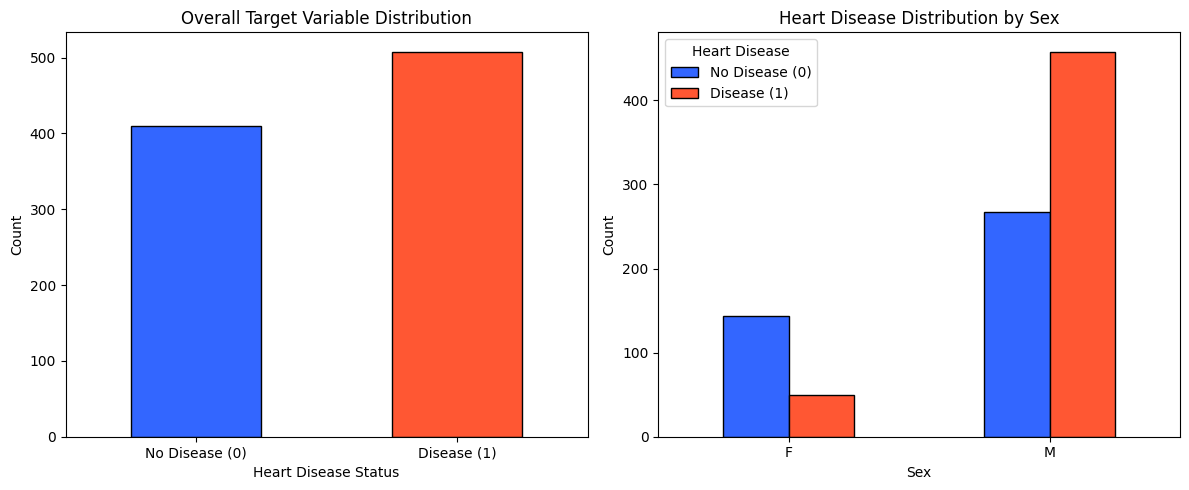

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

# cvd_pd_df = cvd_df.select(col("Sex"), col("HeartDisease").cast("int")).toPandas()


# 2. Create the 1x2 Subplots

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
color_map = {0: "#3366FF", 1: "#FF5733"} # Blue (No HD), Red-Orange (HD)


# Subplot 1: Overall Target Variable Distribution

hd_counts = cvd_pd_df['HeartDisease'].value_counts().sort_index()
colors_overall = [color_map[idx] for idx in hd_counts.index]

hd_counts.plot(kind='bar', color=colors_overall, ax=axes[0], edgecolor='black')
axes[0].set_title('Overall Target Variable Distribution')
axes[0].set_xlabel('Heart Disease Status')
axes[0].set_ylabel('Count')
axes[0].set_xticks(ticks=[0, 1], labels=['No Disease (0)', 'Disease (1)'], rotation=0)


# Subplot 2: Heart Disease Distribution by Sex

sex_hd_counts = cvd_pd_df.groupby(['Sex', 'HeartDisease']).size().unstack(fill_value=0)

sex_hd_counts.plot(kind='bar', stacked=False, ax=axes[1], color=[color_map[0], color_map[1]], edgecolor='black')
axes[1].set_title('Heart Disease Distribution by Sex')
axes[1].set_xlabel('Sex')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(sex_hd_counts.index, rotation=0)

axes[1].legend(title='Heart Disease', labels=['No Disease (0)', 'Disease (1)'])

plt.tight_layout()
plt.savefig('target_distribution_by_sex.png')

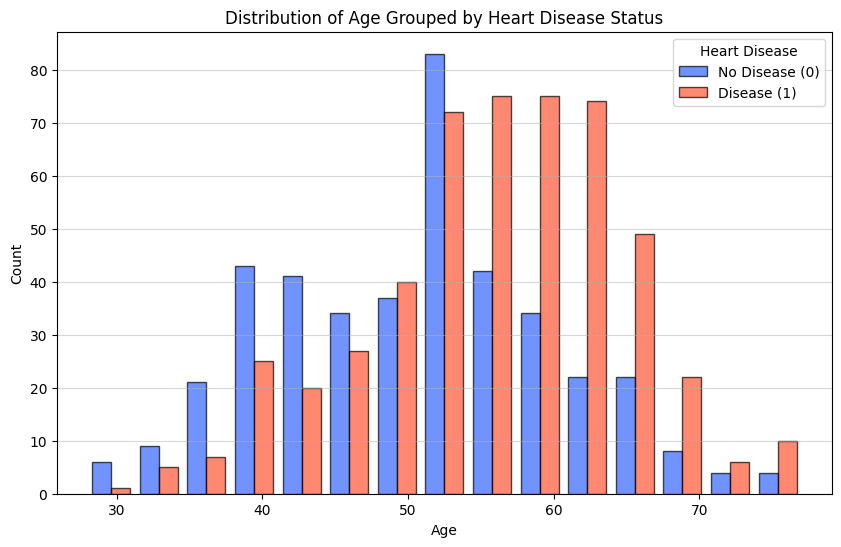

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# 2. Plotting the Grouped Histogram 

custom_colors = ["#3366FF", "#FF5733"] 

plt.figure(figsize=(10, 6))

# Separate the Age column by HeartDisease status
age_no_hd = cvd_pd_df[cvd_pd_df['HeartDisease'] == 0]['Age']
age_yes_hd = cvd_pd_df[cvd_pd_df['HeartDisease'] == 1]['Age']

# Plot the overlapping histograms
plt.hist([age_no_hd, age_yes_hd],
         bins=15, 
         stacked=False,
         color=custom_colors,
         label=['No Disease (0)', 'Disease (1)'],
         edgecolor='black',
         alpha=0.7
        )

plt.title('Distribution of Age Grouped by Heart Disease Status')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend(title='Heart Disease')
plt.grid(axis='y', alpha=0.5)

plt.savefig('age_distribution_custom_color.png')

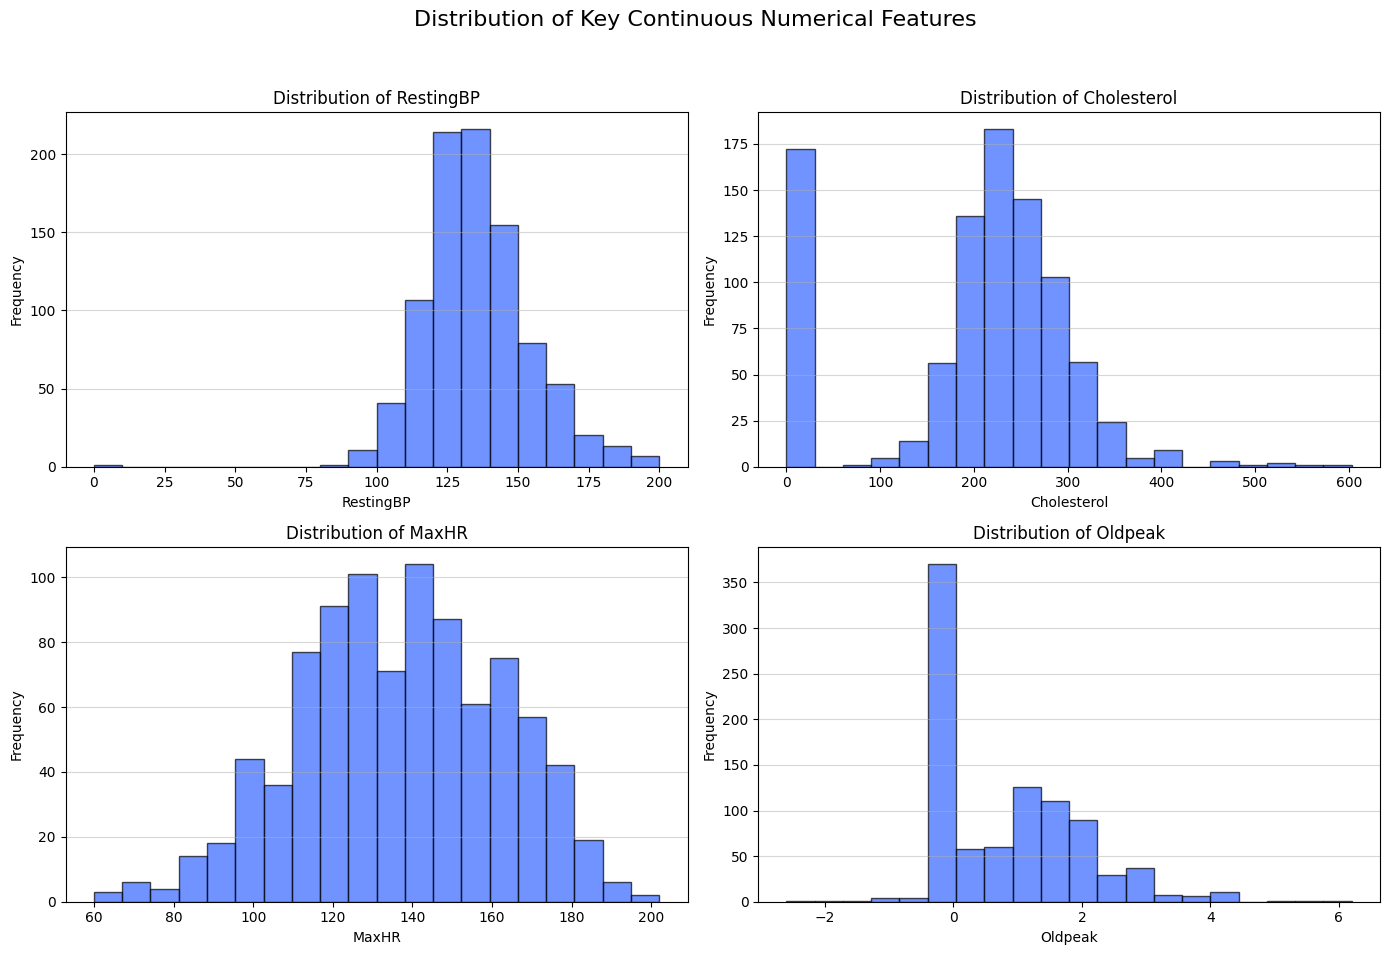

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

# 1. PySpark to Pandas Conversion
# This line creates and defines the 'cvd_pd_num_df' variable.
numerical_cols = ['RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
cvd_pd_num_df = cvd_df.select(*[col(c).cast('double') for c in numerical_cols]).toPandas()


# 2. Create the 2x2 Histogram Subplots 

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
custom_color = "#3366FF" 

for i, col_name in enumerate(numerical_cols):
    row = i // 2
    col_idx = i % 2
    
    # Plotting the histogram
    axes[row, col_idx].hist(cvd_pd_num_df[col_name].dropna(), 
                            bins=20, 
                            color=custom_color, 
                            edgecolor='black', 
                            alpha=0.7)
    
    axes[row, col_idx].set_title(f'Distribution of {col_name}')
    axes[row, col_idx].set_xlabel(col_name)
    axes[row, col_idx].set_ylabel('Frequency')
    axes[row, col_idx].grid(axis='y', alpha=0.5)

fig.suptitle('Distribution of Key Continuous Numerical Features', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('numerical_features_distribution.png')

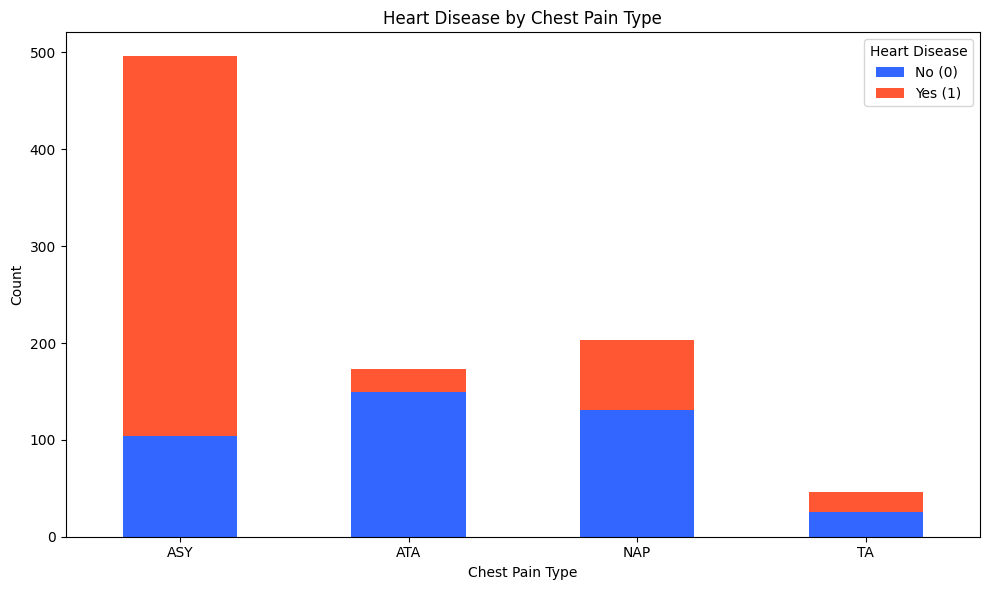

In [25]:
# 3.2 Heart Disease vs. Chest Pain Type (Stacked Bar Chart)
counts = pd.crosstab(cvd_pd_df['ChestPainType'], cvd_pd_df['HeartDisease'])

plt.figure(figsize=(10, 6))
counts.plot(kind='bar', stacked=True, ax=plt.gca(), color=['#3366FF', '#FF5733'])
plt.title('Heart Disease by Chest Pain Type')
plt.xlabel('Chest Pain Type')
plt.ylabel('Count')
plt.legend(title='Heart Disease', labels=['No (0)', 'Yes (1)'])
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

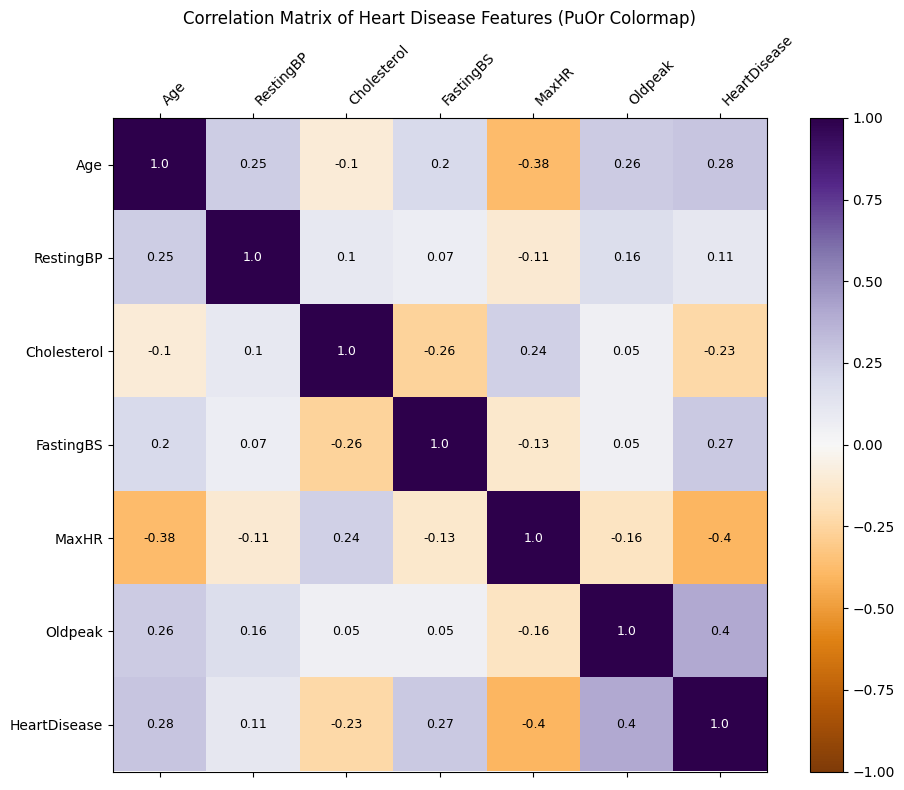

In [26]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. Identify Numeric Columns and Ensure Types 
numeric_cols = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'HeartDisease']

# Ensure numeric columns are cast to a numeric type
for col_name in numeric_cols:
    cvd_df = cvd_df.withColumn(col_name, cvd_df[col_name].cast('double'))

# 2. PySpark Correlation Calculation
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
vector_df = assembler.transform(cvd_df).select("features")
# This is the scalable PySpark step
matrix = Correlation.corr(vector_df, "features").collect()[0][0]

# 3. Visualization Setup (Conversion to Pandas)
corr_matrix_pd = pd.DataFrame(matrix.toArray(), 
                              index=numeric_cols, 
                              columns=numeric_cols)

#  4. Plotting the Heatmap (using Matplotlib with 'PuOr' colormap)

plt.figure(figsize=(10, 8))
ax = plt.gca()

cax = ax.matshow(corr_matrix_pd, cmap='PuOr', vmin=-1, vmax=1)

plt.colorbar(cax)

ax.set_xticks(np.arange(len(numeric_cols)))
ax.set_yticks(np.arange(len(numeric_cols)))
ax.set_xticklabels(numeric_cols, rotation=45, ha='left')
ax.set_yticklabels(numeric_cols)

plt.title('Correlation Matrix of Heart Disease Features (PuOr Colormap)')
plt.tight_layout()

# Annotate the values on the heatmap
for i in range(len(numeric_cols)):
    for j in range(len(numeric_cols)):
        c = round(corr_matrix_pd.iloc[i, j], 2)
        # Ensure text is readable against the background (make it white)
        text_color = 'white' if abs(c) > 0.4 else 'black' 
        ax.text(j, i, str(c), va='center', ha='center', color=text_color, fontsize=9)

plt.savefig('correlation_heatmap_puor.png')

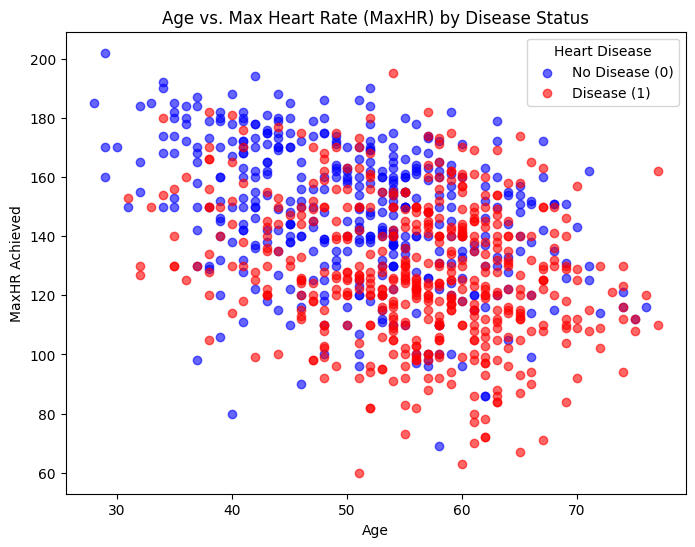

In [27]:
# 3.3 Numeric Correlation (MaxHR vs. Age, colored by HeartDisease)
plt.figure(figsize=(8, 6))
# Plot points for 'No Disease (0)'
plt.scatter(
    cvd_pd_df[cvd_pd_df['HeartDisease'] == 0]['Age'],
    cvd_pd_df[cvd_pd_df['HeartDisease'] == 0]['MaxHR'],
    label='No Disease (0)',
    color='blue',
    alpha=0.6
)
# Plot points for 'Disease (1)'
plt.scatter(
    cvd_pd_df[cvd_pd_df['HeartDisease'] == 1]['Age'],
    cvd_pd_df[cvd_pd_df['HeartDisease'] == 1]['MaxHR'],
    label='Disease (1)',
    color='red',
    alpha=0.6
)
plt.title('Age vs. Max Heart Rate (MaxHR) by Disease Status')
plt.xlabel('Age')
plt.ylabel('MaxHR Achieved')
plt.legend(title='Heart Disease')
plt.show()

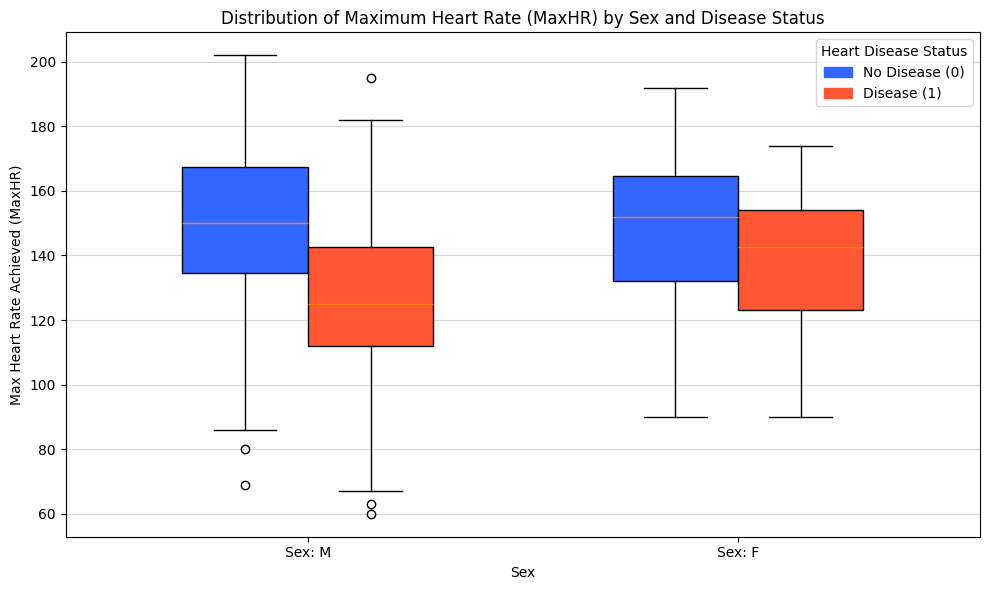

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 

# 1. PySpark to Pandas Conversion
# cvd_pd_df = cvd_df.select("Sex", "MaxHR", "HeartDisease").toPandas()

# Assuming cvd_pd_df is the resulting Pandas DataFrame

# 2. Grouped Box Plot (Matplotlib/Pandas Plotting) 

# Customizing colors for clarity: Orange/Red for Disease, Blue for No Disease
plot_colors = {0: "#3366FF", 1: "#FF5733"} 

plt.figure(figsize=(10, 6))

sexes = cvd_pd_df['Sex'].unique()
data_to_plot = []
labels = []
colors = []
positions = []
width = 0.35

for i, sex in enumerate(sexes):
    for hd_status in [0, 1]:
        subset = cvd_pd_df[(cvd_pd_df['Sex'] == sex) & (cvd_pd_df['HeartDisease'] == hd_status)]
        if not subset.empty:
            data_to_plot.append(subset['MaxHR'].values)
            labels.append(f'{sex} ({hd_status})')
            colors.append(plot_colors[hd_status])
            # Calculate position: 1st group at 1, 2nd group at 1 + width, 3rd group at 2, etc.
            positions.append(i * (2 * width + 0.5) + (hd_status * width))

# Draw the boxplots
box_plot = plt.boxplot(data_to_plot, 
                       positions=positions, 
                       widths=width, 
                       patch_artist=True,
                       showfliers=True) # Show outliers

for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
    
mean_positions = [(i * (2 * width + 0.5) + width / 2) for i in range(len(sexes))]
plt.xticks(mean_positions, [f'Sex: {s}' for s in sexes])

legend_handles = [plt.Rectangle((0,0),1,1, color=plot_colors[hd]) for hd in [0, 1]]
plt.legend(legend_handles, ['No Disease (0)', 'Disease (1)'], title='Heart Disease Status')


plt.title('Distribution of Maximum Heart Rate (MaxHR) by Sex and Disease Status')
plt.xlabel('Sex')
plt.ylabel('Max Heart Rate Achieved (MaxHR)')
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()

plt.savefig('maxhr_grouped_boxplot.png')

## Resilient Distributed Datasets (RDDs)
***
This section demonstrates our proficiency with **RDDs**, the fundamental, fault-tolerant collection in Spark. We use low-level RDD transformations and actions to ensure **scalability** and **performance**:

* **Distributed Aggregation:** Using `map`, `filter`, and `reduceByKey`.
* **Unstructured Processing:** Employing **`flatMap`** to tokenize data.
* **Optimization:** Implementing **`.cache()`** for persistence and the **`aggregate`** action for efficient, single-pass computation.

In [29]:
# Convert DataFrame to RDD
cvd_rdd = cvd_df.rdd

In [30]:
# Compute average cholesterol per age group (filter, map, reduceByKey)

# 1. Filter out missing cholesterol values (unary: filter)
clean_rdd = cvd_rdd.filter(lambda r: r.Cholesterol > 0)

# 2. Convert age into age groups (unary: map)
grouped = clean_rdd.map(lambda r: ((r.Age // 10) * 10, (r.Cholesterol, 1)))
# e.g. (50, (250, 1)) → age group 50–59

# 3. Reduce by key (pair transformation)
reduced = grouped.reduceByKey(lambda a, b: (a[0]+b[0], a[1]+b[1]))

# 4. Compute final averages
avg_chol_by_age_group = reduced.map(lambda x: (x[0], x[1][0] / x[1][1]))

print(avg_chol_by_age_group.collect())

[(40.0, 241.717277486911), (30.0, 233.87878787878788), (50.0, 246.5808580858086), (60.0, 252.3375796178344), (20.0, 210.5), (70.0, 228.84)]


In [31]:
# Combine all older males and older females into one RDD of “older patients”. (filter, union)

older_males = cvd_rdd.filter(lambda r: r.Sex == "M" and r.Age > 50)
older_females = cvd_rdd.filter(lambda r: r.Sex == "F" and r.Age > 50)

older_patients = older_males.union(older_females)

print("Older patients (via union):")
print(older_patients.take(10))



Older patients (via union):
[Row(Age=54.0, Sex='M', ChestPainType='NAP', RestingBP=150.0, Cholesterol=195.0, FastingBS=0.0, RestingECG='Normal', MaxHR=122.0, ExerciseAngina='N', Oldpeak=0.0, ST_Slope='Up', HeartDisease=0.0), Row(Age=54.0, Sex='M', ChestPainType='ATA', RestingBP=110.0, Cholesterol=208.0, FastingBS=0.0, RestingECG='Normal', MaxHR=142.0, ExerciseAngina='N', Oldpeak=0.0, ST_Slope='Up', HeartDisease=0.0), Row(Age=58.0, Sex='M', ChestPainType='ATA', RestingBP=136.0, Cholesterol=164.0, FastingBS=0.0, RestingECG='ST', MaxHR=99.0, ExerciseAngina='Y', Oldpeak=2.0, ST_Slope='Flat', HeartDisease=1.0), Row(Age=60.0, Sex='M', ChestPainType='ASY', RestingBP=100.0, Cholesterol=248.0, FastingBS=0.0, RestingECG='Normal', MaxHR=125.0, ExerciseAngina='N', Oldpeak=1.0, ST_Slope='Flat', HeartDisease=1.0), Row(Age=53.0, Sex='M', ChestPainType='ASY', RestingBP=124.0, Cholesterol=260.0, FastingBS=0.0, RestingECG='ST', MaxHR=112.0, ExerciseAngina='Y', Oldpeak=3.0, ST_Slope='Flat', HeartDisease=

In [32]:
# Count patients per ChestPainType (map, reduceByKey)

cp_counts = cvd_rdd.map(lambda row: (row.ChestPainType, 1)) \
                   .reduceByKey(lambda a, b: a + b)

print("Number of patients per ChestPainType:")
for cp, count in cp_counts.collect():
    print(f"{cp}: {count}")

Number of patients per ChestPainType:
ATA: 173
NAP: 203
ASY: 496
TA: 46


In [33]:
# Average max heart rate achieved by sex (map, reduceByKey)

# Map to (Sex, (MaxHR, 1))
sex_maxhr = cvd_rdd.map(lambda row: (row.Sex, (row.MaxHR, 1)))

# Reduce by key to sum MaxHR and counts
sex_maxhr_sum = sex_maxhr.reduceByKey(lambda a, b: (a[0]+b[0], a[1]+b[1]))

# Compute average
avg_maxhr_by_sex = sex_maxhr_sum.mapValues(lambda x: x[0]/x[1])

print("Average MaxHR by Sex:")
for sex, avg in avg_maxhr_by_sex.collect():
    print(f"{sex}: {avg:.2f}")

Average MaxHR by Sex:
M: 134.33
F: 146.14


In [34]:
#Filter high-risk patients (filter)

# High-risk: FastingBS > 120 or ExerciseAngina == 'Y'
high_risk_rdd = cvd_rdd.filter(lambda row: row.FastingBS == 1 or row.ExerciseAngina == 'Y')

print(f"Total high-risk patients: {high_risk_rdd.count()}")


Total high-risk patients: 487


In [35]:
# Top 5 oldest patients with heart disease (filter)

heart_patients = cvd_rdd.filter(lambda row: row.HeartDisease == 1)
top_oldest = heart_patients.takeOrdered(5, key=lambda row: -row.Age)

print("Top 5 oldest patients with heart disease:")
for row in top_oldest:
    print(f"Age: {row.Age}, Sex: {row.Sex}, ChestPainType: {row.ChestPainType}")


Top 5 oldest patients with heart disease:
Age: 77.0, Sex: M, ChestPainType: ASY
Age: 77.0, Sex: M, ChestPainType: ASY
Age: 76.0, Sex: M, ChestPainType: NAP
Age: 75.0, Sex: M, ChestPainType: ASY
Age: 75.0, Sex: M, ChestPainType: ASY


In [36]:
# Distribution of ChestPainType among high-risk patients

cp_high_risk = high_risk_rdd.map(lambda row: (row.ChestPainType, 1)) \
                             .reduceByKey(lambda a, b: a + b)

print("ChestPainType counts among high-risk patients:")
for cp, count in cp_high_risk.collect():
    print(f"{cp}: {count}")


ChestPainType counts among high-risk patients:
ASY: 359
ATA: 31
NAP: 79
TA: 18


In [37]:
# Aggregate over RestingBP: (Sum_BP, Count)

# Cache the RDD to speed up subsequent actions
cvd_rdd.cache()

# Define the accumulator (zero value): (sum_BP, count)
zero_value = (0, 0)

# Define the sequence operation (seqOp)
# Applied within each partition: (current_sum, current_count) + new_row.RestingBP
def seqOp(accumulator, row):
    return (accumulator[0] + row.RestingBP, accumulator[1] + 1)

# Define the combine operation (combOp)
# Applied between partitions: (sum_A, count_A) + (sum_B, count_B)
def combOp(acc1, acc2):
    return (acc1[0] + acc2[0], acc1[1] + acc2[1])

# Perform the aggregation
total_bp_sum, total_count = cvd_rdd.aggregate(zero_value, seqOp, combOp)

print("\nRDD Persistence and Aggregate Demonstration:")
print(f"Total RestingBP Sum (via aggregate): {total_bp_sum}")
print(f"Total Patient Count (via aggregate): {total_count}")
print(f"Average RestingBP: {total_bp_sum / total_count:.2f}")

cvd_rdd.unpersist() 


RDD Persistence and Aggregate Demonstration:
Total RestingBP Sum (via aggregate): 121540.0
Total Patient Count (via aggregate): 918
Average RestingBP: 132.40


MapPartitionsRDD[94] at javaToPython at NativeMethodAccessorImpl.java:0

# Machine learning and pipelines

In this section, we compare four different classification algorithms to determine which best predicts heart disease. To ensure a fair comparison, all models are trained and tested on the exact same data splits.

**1. Logistic Regression (with Tuning)**
We start with a standard Logistic Regression pipeline using One-Hot Encoding for categorical features. We also apply Cross-Validation to automatically find the best hyperparameters (regularization strength) to optimize performance.

**2. Random Forest Classifier**
Next, we train a Random Forest model. Since tree-based models handle categorical data differently, we adjusted the pipeline to use simple String Indexing rather than One-Hot Encoding, which is more efficient for this algorithm.

**3. Support Vector Machine (Linear SVC)**
We also test a Linear Support Vector Machine. Like Logistic Regression, this model requires One-Hot Encoding to mathematically interpret categorical features correctly.

**4. Neural Network (Multilayer Perceptron)**
Finally, we implement a Feedforward Neural Network. This requires an additional preprocessing step - **Standard Scaling** - to normalize all features (e.g., Age vs. Cholesterol) to the same range, ensuring the network learns effectively.

**Evaluation Metrics**
For all models, we calculate the following metrics to judge performance:
* **AUC:** Measures the model's ability to distinguish between classes (ranking).
* **Accuracy, Precision, Recall, and F1:** These metrics help us understand the specific trade-offs between false positives and false negatives, which is critical in medical diagnosis.

+--------------------------------------------------------------------+------------+----------+-----------------------------------------+
|features                                                            |HeartDisease|prediction|probability                              |
+--------------------------------------------------------------------+------------+----------+-----------------------------------------+
|[29.0,130.0,204.0,0.0,202.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0]|0           |0.0       |[0.961998782559761,0.03800121744023899]  |
|[31.0,120.0,270.0,0.0,153.0,1.5,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0]|1           |1.0       |[0.067147169856666,0.932852830143334]    |
|[32.0,118.0,529.0,0.0,130.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0]|1           |1.0       |[0.36340886325866634,0.6365911367413337] |
|[32.0,110.0,225.0,0.0,184.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0]|0           |0.0       |[0.9698550678570371,0.030144932142962877]|
|[33.0,120.0,298.0,0.0,185.0,0.0,1.0,0.0,

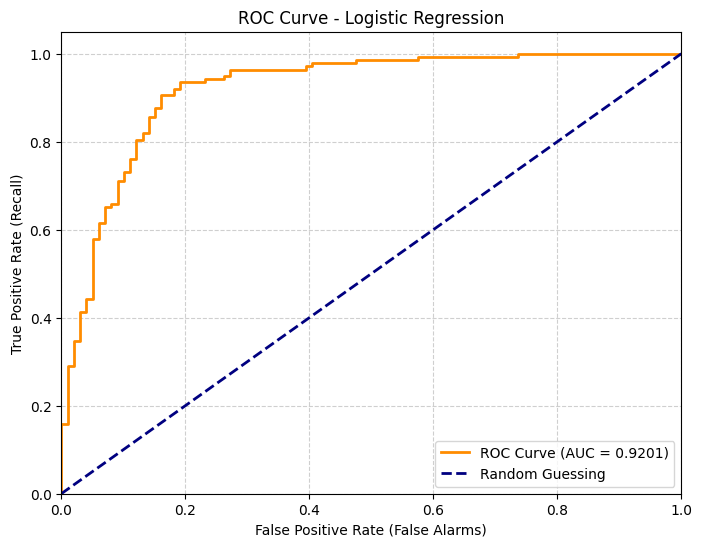

In [74]:
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.types import FloatType
from sklearn.metrics import roc_curve, auc as sk_auc #

# 1. Prepare Data

# Load data
cvd_df = spark.read.csv("heart.csv", header=True, inferSchema=True)

# Categorical + numeric columns
categorical_cols = ["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope"]
numeric_cols = ["Age","RestingBP","Cholesterol","FastingBS","MaxHR","Oldpeak"]

# Index and encode categoricals
indexers = [StringIndexer(inputCol=c, outputCol=c+"_idx") for c in categorical_cols]
encoder = OneHotEncoder(inputCols=[c+"_idx" for c in categorical_cols],
                        outputCols=[c+"_ohe" for c in categorical_cols])

# Assemble features
assembler = VectorAssembler(
    inputCols=numeric_cols + [c+"_ohe" for c in categorical_cols],
    outputCol="features"
)

# Classifier
lr = LogisticRegression(featuresCol="features", labelCol="HeartDisease")

# Pipeline
pipeline = Pipeline(stages=indexers + [encoder, assembler, lr])

# Train/test split
train_df, test_df = cvd_df.randomSplit([0.7, 0.3], seed=42)

# Fit
model = pipeline.fit(train_df)

# Predict
predictions = model.transform(test_df)
predictions.select("features", "HeartDisease", "prediction", "probability").show(5, truncate=False)

# 2. Evaluation Metrics

# AUC (Area Under ROC)
evaluator_auc = BinaryClassificationEvaluator(labelCol="HeartDisease", metricName="areaUnderROC")
auc_score = evaluator_auc.evaluate(predictions) # CHANGED VARIABLE NAME
print(f"AUC:                  {auc_score:.4f}")

# Accuracy, Precision, Recall, F1
multi_evaluator = MulticlassClassificationEvaluator(labelCol="HeartDisease", metricName="accuracy")

accuracy = multi_evaluator.evaluate(predictions)
precision = multi_evaluator.setMetricName("weightedPrecision").evaluate(predictions)
recall = multi_evaluator.setMetricName("weightedRecall").evaluate(predictions)
f1_score = multi_evaluator.setMetricName("f1").evaluate(predictions)

print(f"Accuracy:             {accuracy:.4f}")
print(f"Weighted Precision:   {precision:.4f}")
print(f"Weighted Recall:      {recall:.4f}")
print(f"F1 Score:             {f1_score:.4f}")

# 3. Plot ROC Curve

# Extract the "Probability of Class 1" (Heart Disease)
# The 'probability' column is a vector [prob_0, prob_1]. We need prob_1.
first_element_udf = udf(lambda v: float(v[1]), FloatType())

# Select only the necessary columns and convert to Pandas for plotting
preds_pd = predictions.select("HeartDisease", first_element_udf("probability").alias("score")) \
                      .toPandas()

# Calculate ROC coordinates using sklearn
fpr, tpr, thresholds = roc_curve(preds_pd["HeartDisease"], preds_pd["score"])
roc_auc_val = sk_auc(fpr, tpr) 

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc_val:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (False Alarms)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [76]:
# 1. Define the Hyperparameter Grid
# We test different regularization strengths (regParam) and mixing ratios (elasticNetParam)
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.1, 0.5])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .build())

# 2. Setup Cross-Validator
# This splits the data into 3 folds, training 9 models (3x3 grid) for every fold
cv = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator, 
    numFolds=3,
    seed=42
)

# 3. Training
cv_model = cv.fit(train_df)

# 4. Predict on Test Data
cv_predictions = cv_model.transform(test_df)

# EVALUATION METRICS

# 1. AUC (Area Under ROC) - The ability to distinguish classes
auc = evaluator.evaluate(cv_predictions)
print(f"Area Under ROC (AUC): {auc:.4f}")

# 2. Other Metrics (Accuracy, Precision, Recall, F1)
multi_evaluator = MulticlassClassificationEvaluator(labelCol="HeartDisease", metricName="accuracy")

accuracy = multi_evaluator.evaluate(cv_predictions)
precision = multi_evaluator.setMetricName("weightedPrecision").evaluate(cv_predictions)
recall = multi_evaluator.setMetricName("weightedRecall").evaluate(cv_predictions)
f1_score = multi_evaluator.setMetricName("f1").evaluate(cv_predictions)

print(f"Accuracy:             {accuracy:.4f}")
print(f"Weighted Precision:   {precision:.4f}")
print(f"Weighted Recall:      {recall:.4f}")
print(f"F1 Score:             {f1_score:.4f}")


Area Under ROC (AUC): 0.9245
Accuracy:             0.8819
Weighted Precision:   0.8819
Weighted Recall:      0.8819
F1 Score:             0.8813


In [77]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
# 1. Define the Random Forest Pipeline Steps
categorical_cols = ["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope"]
numeric_cols = ["Age", "RestingBP", "Cholesterol", "FastingBS", "MaxHR", "Oldpeak"]

# Step A: Convert text to numbers (Indexers)
indexers = [
    StringIndexer(inputCol=c, outputCol=c+"_idx", handleInvalid="keep") 
    for c in categorical_cols
]

# Step B: Assemble features into a single vector
assembler = VectorAssembler(
    inputCols=numeric_cols + [c+"_idx" for c in categorical_cols], 
    outputCol="features"
)

# Step C: The Classifier
rf = RandomForestClassifier(labelCol="HeartDisease", featuresCol="features", seed=42)

# 2. Build the Pipeline
# We bundle preprocessing + model into one object
rf_pipeline = Pipeline(stages=indexers + [assembler, rf])

# 3. Train on the train_df
rf_model = rf_pipeline.fit(train_df)

# 4. Predict on the test_df
rf_predictions = rf_model.transform(test_df)

# 5. Evaluation

# AUC
bin_evaluator = BinaryClassificationEvaluator(labelCol="HeartDisease")
auc = bin_evaluator.evaluate(rf_predictions)
print(f"AUC: {auc:.4f}")

# Accuracy, Precision, Recall, F1
multi_evaluator = MulticlassClassificationEvaluator(labelCol="HeartDisease", metricName="accuracy")

accuracy = multi_evaluator.evaluate(rf_predictions)
precision = multi_evaluator.setMetricName("weightedPrecision").evaluate(rf_predictions)
recall = multi_evaluator.setMetricName("weightedRecall").evaluate(rf_predictions)
f1_score = multi_evaluator.setMetricName("f1").evaluate(rf_predictions)

print(f"Accuracy:             {accuracy:.4f}")
print(f"Weighted Precision:   {precision:.4f}")
print(f"Weighted Recall:      {recall:.4f}")
print(f"F1 Score:             {f1_score:.4f}")


AUC: 0.9268
Accuracy:             0.8523
Weighted Precision:   0.8519
Weighted Recall:      0.8523
F1 Score:             0.8517


In [78]:
from pyspark.ml.classification import LinearSVC

# 1. Define Preprocessing 
# We MUST use OneHotEncoder for SVM, so we redefine these steps.
categorical_cols = ["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope"]
numeric_cols = ["Age", "RestingBP", "Cholesterol", "FastingBS", "MaxHR", "Oldpeak"]

indexers = [
    StringIndexer(inputCol=c, outputCol=c+"_idx", handleInvalid="keep") 
    for c in categorical_cols
]

encoder = OneHotEncoder(
    inputCols=[c+"_idx" for c in categorical_cols],
    outputCols=[c+"_ohe" for c in categorical_cols]
)

assembler = VectorAssembler(
    inputCols=numeric_cols + [c+"_ohe" for c in categorical_cols],
    outputCol="features"
)

# 2. Define the SVM Model
# maxIter=50 - it tries 50 times to find the best line.
svm = LinearSVC(featuresCol="features", labelCol="HeartDisease", maxIter=50, regParam=0.1)

# 3. Build Pipeline
pipeline_svm = Pipeline(stages=indexers + [encoder, assembler, svm])

# 4. Train
svm_model = pipeline_svm.fit(train_df)

# 5. Predict
predictions_svm = svm_model.transform(test_df)

# 6. Evaluation

# AUC (Uses 'rawPrediction')
# (SVM doesn't output 'probability', it outputs 'rawPrediction' (distance from the line).)
evaluator_auc = BinaryClassificationEvaluator(
    labelCol="HeartDisease",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)
auc_svm = evaluator_auc.evaluate(predictions_svm)
print(f"AUC:                  {auc_svm:.4f}")

multi_evaluator = MulticlassClassificationEvaluator(labelCol="HeartDisease", metricName="accuracy")

accuracy = multi_evaluator.evaluate(predictions_svm)
precision = multi_evaluator.setMetricName("weightedPrecision").evaluate(predictions_svm)
recall = multi_evaluator.setMetricName("weightedRecall").evaluate(predictions_svm)
f1_score = multi_evaluator.setMetricName("f1").evaluate(predictions_svm)

print(f"Accuracy:             {accuracy:.4f}")
print(f"Weighted Precision:   {precision:.4f}")
print(f"Weighted Recall:      {recall:.4f}")
print(f"F1 Score:             {f1_score:.4f}")

AUC:                  0.9197
Accuracy:             0.8523
Weighted Precision:   0.8526
Weighted Recall:      0.8523
F1 Score:             0.8524


In [83]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.feature import StandardScaler

# Multi layer perceptron

# 1. Scaling 
#  We take the vector from 'assembler' and squash all numbers to be on the same scale (roughly -1 to 1).
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=True)

# 2. Get Input Size
prep_pipeline = Pipeline(stages=indexers + [encoder, assembler])
processed_data = prep_pipeline.fit(train_df).transform(train_df)
input_dim = len(processed_data.first()["features"])

print(f"Input Feature Dimension: {input_dim}")

# 3. Architecture
# [Input, 64 neurons, 32 neurons, 2 output]
# We make the network wider (64/32) so it can learn complex relationships.
layers = [input_dim, 64, 32, 2]

# 4. Configure the Network

mlp = MultilayerPerceptronClassifier(
    layers=layers,
    blockSize=128,
    seed=42,
    maxIter=1000,
    featuresCol="scaledFeatures", 
    labelCol="HeartDisease"
)

# 5. Build Pipeline
# Index -> Encode -> Assemble -> SCALE -> Model
pipeline_nn = Pipeline(stages=indexers + [encoder, assembler, scaler, mlp])

# 6. Train
nn_model = pipeline_nn.fit(train_df)

# 7. Predict
predictions_nn = nn_model.transform(test_df)

# 8. Evaluate
evaluator_auc = BinaryClassificationEvaluator(labelCol="HeartDisease", metricName="areaUnderROC")
auc_nn = evaluator_auc.evaluate(predictions_nn)

multi_evaluator = MulticlassClassificationEvaluator(labelCol="HeartDisease", metricName="accuracy")
acc_nn = multi_evaluator.evaluate(predictions_nn)

# Metrics

evaluator_auc = BinaryClassificationEvaluator(labelCol="HeartDisease", metricName="areaUnderROC")
auc_nn = evaluator_auc.evaluate(predictions_nn)
print(f"Area Under ROC (AUC): {auc_nn:.4f}")

multi_evaluator = MulticlassClassificationEvaluator(labelCol="HeartDisease", metricName="accuracy")

accuracy = multi_evaluator.evaluate(predictions_nn)
precision = multi_evaluator.setMetricName("weightedPrecision").evaluate(predictions_nn)
recall = multi_evaluator.setMetricName("weightedRecall").evaluate(predictions_nn)
f1_score = multi_evaluator.setMetricName("f1").evaluate(predictions_nn)

print(f"Accuracy:             {accuracy:.4f}")
print(f"Weighted Precision:   {precision:.4f}")
print(f"Weighted Recall:      {recall:.4f}")
print(f"F1 Score:             {f1_score:.4f}")

Input Feature Dimension: 20
Area Under ROC (AUC): 0.8876
Accuracy:             0.8397
Weighted Precision:   0.8458
Weighted Recall:      0.8397
F1 Score:             0.8406
